In [1]:
#Figure 5 graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [1]:
#Basic importing set: 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import statsmodels.api as sm

#Image Tools:
from tifffile import TiffFile, TiffWriter
from skimage.measure import regionprops as rgnprops

In [2]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Lets start by importing the meta dataframe and then pairing them to the wavefile csvs we want to analyze. 
#analysis_set = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/2022_06_01_Set')

base_path = Path.cwd().parent / Path('Data Sets/2023_01_24_main-set/')
meta_df_path = base_path / 'analysis_DF.csv'
analysis_output_destination = base_path / 'wavefit_outputs'

#There are three important dataframes used in analysis, the wave data frame, the ARCOS df, and the tracking df with binnned calcium values:
#The tracking is the most broad, followed by ARCOS and then the wave (most abstracted info):
wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])
meta_DF = pd.read_csv(meta_df_path)
wave_con_df = consolidate_waves(wave_dataframe_paths)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 653.98it/s]


In [4]:
image_file_loc = base_path / 'images'
seg_file_loc = base_path / 'segmented_nuclei'

image_list = sorted(image_file_loc.glob('[!.]*.tif'),  key=lambda x: x.stem.split('_')[0])
seg_list = sorted(seg_file_loc.glob('[!.]*.tif'),  key=lambda x: x.stem.split('_')[0])


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0.5, 0, '')

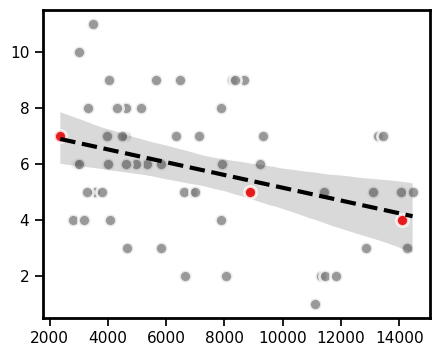

In [5]:
wave_threshold_DF = wave_con_df[wave_con_df['circle_radius'] > 100]

num_v_den = pd.merge(wave_threshold_DF.groupby('image_ID').cell_density.mean(), wave_threshold_DF.groupby('image_ID').wave_ID.nunique(), right_index=True, left_index=True)
represenative_pts = num_v_den.loc[[84, 65, 79]]

#sns.scatterplot(data=num_v_den, x='cell_density', y='wave_ID')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
plt.figure(figsize=(5,4))
sns.scatterplot(data = num_v_den, x='cell_density', y='wave_ID', s=75, linewidth=2, color='grey', alpha=0.8, legend=False)
sns.regplot(data= num_v_den, x='cell_density', y='wave_ID', scatter_kws={'alpha':0}, line_kws={'color':'black', 'linestyle':'--'})
sns.scatterplot(data = represenative_pts, x='cell_density', y='wave_ID', s=75, linewidth=2, color='red', alpha=0.8, legend=False)
plt.ylabel('')
plt.xlabel('')
#plt.savefig('fig5-density-v-wave-number.png', dpi=300, bbox_inches='tight')


In [6]:
fit_xs_5numvden = num_v_den['cell_density'].values
fit_xs_5numvden = sm.add_constant(fit_xs_5numvden)
fit_ys_5numvden = num_v_den['wave_ID'].values
model_5numvden = sm.OLS(fit_ys_5numvden,fit_xs_5numvden)
results_5numvden = model_5numvden.fit()
print(results_5numvden.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     8.214
Date:                Mon, 12 Feb 2024   Prob (F-statistic):            0.00588
Time:                        18:45:08   Log-Likelihood:                -123.62
No. Observations:                  57   AIC:                             251.2
Df Residuals:                      55   BIC:                             255.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4269      0.639     11.629      0.0

In [7]:
#Can find waves in a range of final radii, look at density to find representative examples. 
wave_number_group = num_v_den[num_v_den['wave_ID'].between(7,9)]
wave_number_group[wave_number_group['cell_density'].between(2000,3000)]
#First represenative example is image 84

,cell_density,wave_ID
image_ID,,
84,2368.716849,7


In [12]:
#Get the file path for the wanted image: 
image_number = 84
im_name = image_list[52] #Image 84
#Get the waves for the image number wanted
ex_waves_in_image = wave_con_df[wave_con_df['image_ID']==image_number]
waves_above_threshold = ex_waves_in_image.groupby('clTrackID').circle_radius.max() > 100
waves_above_threshold = ex_waves_in_image.set_index('clTrackID').loc[waves_above_threshold[waves_above_threshold].index]

ca_wave_collect = []
#Get the corresponding segmented nuclei file:

ca_means = []
times = []

#Loop through the opened image file, get the mean of the calcium channel instensity

with TiffFile(im_name) as im:
    pages = im.pages
    j = 0
    t = 0

    for page in pages:
        if j%2 == 0:
            im_pg = page.asarray()
            ca_m = im_pg.mean()
            times.append(t)
            ca_means.append(ca_m)
            j += 1
            t += 1
        else:
            j += 1


In [19]:
print(ex_waves_in_image['wave_ID'].unique())
print(waves_above_threshold['wave_ID'].unique())

['84-6' '84-11' '84-25' '84-30' '84-34' '84-38' '84-39']
['84-6' '84-11' '84-25' '84-30' '84-34' '84-38' '84-39']


(313.10533155119924, 335.0)

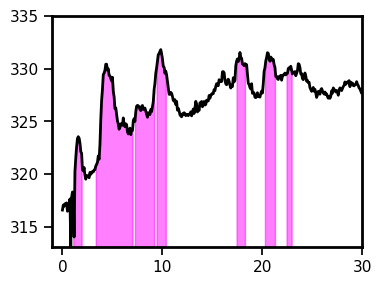

In [20]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

initial_timepoint = ex_waves_in_image.timepoint.min()
pre_waves_time = initial_timepoint - 12

calcium_activity_window = ca_means[pre_waves_time:]
min_cal_signal = min(calcium_activity_window)
real_time_array = (np.array(range(len(calcium_activity_window)))*5.0)/60.0

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(real_time_array, calcium_activity_window, color='k')

for wid, wave in ex_waves_in_image.groupby('wave_ID'):
    wave_start_time = (wave.timepoint.min() - pre_waves_time)*5.0/60.0
    wave_end_time = (wave.timepoint.max() - pre_waves_time)*5.0/60.0
    ax.fill_between(real_time_array, min_cal_signal, calcium_activity_window, where=np.logical_and(wave_end_time>real_time_array, real_time_array>wave_start_time), color='magenta', alpha=0.5)

plt.xlim(-1,30)
plt.ylim(min_cal_signal,335)
#plt.savefig('calcium_traces/sup-fig4-density-v-wavenum_calcium-arcos-events_image{}.png'.format(image_number), dpi=300, bbox_inches='tight')

In [21]:
#Can find waves in a range of final radii, look at density to find representative examples. 
wave_number_group = num_v_den[num_v_den['wave_ID'].between(4,5)]
wave_number_group[wave_number_group['cell_density'].between(8000,9000)]
#First represenative example is image 65

,cell_density,wave_ID
image_ID,,
65,8867.214133,5


In [22]:
#Get the file path for the wanted image: 
image_number = 65
im_name = image_list[33] #Image 65
#Get the waves for the image number wanted above the minimum threshold
ex_waves_in_image = wave_con_df[wave_con_df['image_ID']==image_number]
waves_above_threshold = ex_waves_in_image.groupby('clTrackID').circle_radius.max() > 100
waves_above_threshold = ex_waves_in_image.set_index('clTrackID').loc[waves_above_threshold[waves_above_threshold].index]

ca_wave_collect = []
#Get the corresponding segmented nuclei file:

ca_means = []
times = []

#Loop through the opened image file, get the mean of the calcium channel instensity

with TiffFile(im_name) as im:
    pages = im.pages
    j = 0
    t = 0

    for page in pages:
        if j%2 == 0:
            im_pg = page.asarray()
            ca_m = im_pg.mean()
            times.append(t)
            ca_means.append(ca_m)
            j += 1
            t += 1
        else:
            j += 1


(383.92215539219325, 407.0)

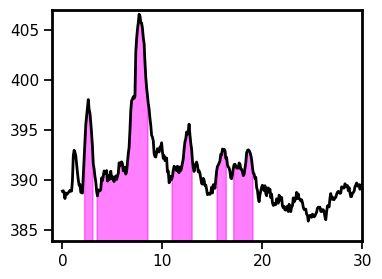

In [24]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

initial_timepoint = ex_waves_in_image.timepoint.min()
pre_waves_time = initial_timepoint - 12

calcium_activity_window = ca_means[pre_waves_time:]
min_cal_signal = min(calcium_activity_window)
real_time_array = (np.array(range(len(calcium_activity_window)))*5.0)/60.0

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(real_time_array, calcium_activity_window, color='k')

for wid, wave in waves_above_threshold.groupby('wave_ID'):
    wave_start_time = (wave.timepoint.min() - pre_waves_time)*5.0/60.0
    wave_end_time = (wave.timepoint.max() - pre_waves_time)*5.0/60.0
    ax.fill_between(real_time_array, min_cal_signal, calcium_activity_window, where=np.logical_and(wave_end_time>real_time_array, real_time_array>wave_start_time), color='magenta', alpha=0.5)

plt.xlim(-1,30)
plt.ylim(min_cal_signal,407)
#plt.savefig('calcium_traces/sup-fig4-density-v-wavenum_calcium-arcos-events_image{}.png'.format(image_number), dpi=300, bbox_inches='tight')

In [25]:
#Can find waves in a range of final radii, look at density to find representative examples. 
wave_number_group = num_v_den[num_v_den['wave_ID'].between(4,5)]
wave_number_group[wave_number_group['cell_density'].between(14000,15000)]
#First represenative example is image 79

,cell_density,wave_ID
image_ID,,
44,14064.294945,5
79,14083.839414,4
80,14451.974139,5


In [26]:
#Get the file path for the wanted image: 
image_number = 79
im_name = image_list[47] #Image 79
#Get the waves for the image number wanted above the minimum threshold
ex_waves_in_image = wave_con_df[wave_con_df['image_ID']==image_number]
waves_above_threshold = ex_waves_in_image.groupby('clTrackID').circle_radius.max() > 100
waves_above_threshold = ex_waves_in_image.set_index('clTrackID').loc[waves_above_threshold[waves_above_threshold].index]

ca_wave_collect = []
#Get the corresponding segmented nuclei file:

ca_means = []
times = []

#Loop through the opened image file, get the mean of the calcium channel instensity

with TiffFile(im_name) as im:
    pages = im.pages
    j = 0
    t = 0

    for page in pages:
        if j%2 == 0:
            im_pg = page.asarray()
            ca_m = im_pg.mean()
            times.append(t)
            ca_means.append(ca_m)
            j += 1
            t += 1
        else:
            j += 1


In [27]:
print(ex_waves_in_image['wave_ID'].unique())
print(waves_above_threshold['wave_ID'].unique())

['79-12' '79-18' '79-6' '79-7' '79-27']
['79-7' '79-12' '79-18' '79-27']


(392.61031286354296, 450.0)

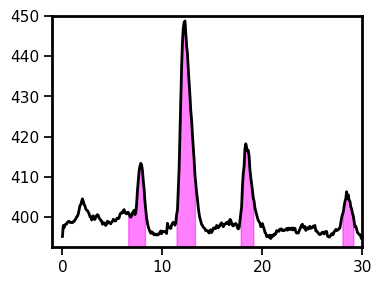

In [28]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

initial_timepoint = ex_waves_in_image.timepoint.min()
pre_waves_time = initial_timepoint - 12

calcium_activity_window = ca_means[pre_waves_time:]
min_cal_signal = min(calcium_activity_window)
real_time_array = (np.array(range(len(calcium_activity_window)))*5.0)/60.0

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(real_time_array, calcium_activity_window, color='k')

for wid, wave in waves_above_threshold.groupby('wave_ID'):
    wave_start_time = (wave.timepoint.min() - pre_waves_time)*5.0/60.0
    wave_end_time = (wave.timepoint.max() - pre_waves_time)*5.0/60.0
    ax.fill_between(real_time_array, min_cal_signal-2, calcium_activity_window, where=np.logical_and(wave_end_time>real_time_array, real_time_array>wave_start_time), color='magenta', alpha=0.5)

plt.xlim(-1,30)
plt.ylim(min_cal_signal-2,450)
#plt.savefig('calcium_traces/sup-fig4-density-v-wavenum_calcium-arcos-events_image{}.png'.format(image_number), dpi=300, bbox_inches='tight')